In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier as xgb
import xgboost as xg
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


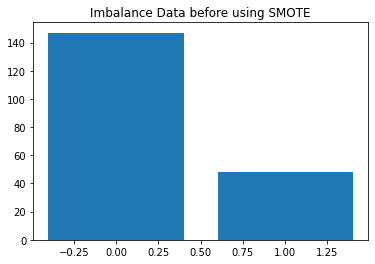

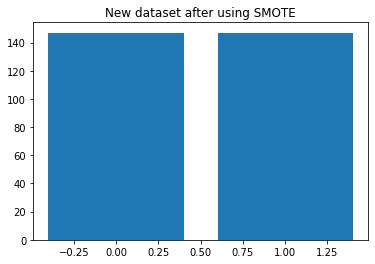

In [33]:
#reading the data to Final_Data  
Final_Data = pd.read_csv('Parkinsons.csv')

# Poping out the status of Parkinson's Disease in patients
y = Final_Data.pop('status')
name  = Final_Data.pop('name')

#storing the new data to varibale x
x = Final_Data

# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='auto', random_state=7)

# Fit the model to generate the new balanced data.
oversampled_trainX, oversampled_trainY = sm.fit_resample(x, y)
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainX), pd.DataFrame(oversampled_trainY)], axis=1)

# plotting the y=0 and y=1 values by giving the dataframe as argument
def plot(X):
  x_0=0
  x_1=0
  for i in range(len(X)):
    if(X[i]==1):
      x_0 = x_0+1
    else:
      x_1 = x_1+1

  x_values = [0,1]
  y_values = [x_0,x_1]

  plt.bar(x_values,y_values)
  plt.show()
  return 

#Representation of data before and after oversampling
plt.title("Imbalance Data before using SMOTE")
plot(y)

plt.title("New dataset after using SMOTE")
plot(oversampled_trainY)


In [35]:
#feature selection using Lasso
pipeline = Pipeline([ ('scaler', StandardScaler()), ('model', Lasso()) ])
search = GridSearchCV(pipeline, {'model__alpha':np.arange(0.1,10,0.1)}, scoring='neg_mean_squared_error', cv=5)
search.fit(oversampled_trainX, oversampled_trainY)
search.best_params_
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)
features = oversampled_trainX.columns
selected_features = features[importance>0]
dropped_features = features[importance==0]
X_final = oversampled_trainX.drop(dropped_features, axis = 'columns')
selected_features

Index(['spread1', 'spread2'], dtype='object')

In [37]:
#divding data into training and testing data in 0.8 and 0.2 proportion respectively
X_train, X_test, Y_train, Y_test = train_test_split(oversampled_trainX, oversampled_trainY,test_size = 0.2, random_state = 23)

# SVC Model
clf = SVC()
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
#print(y_pred)
YY = [y_pred, Y_test]

#The results of the SVC model prediction 

print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test,y_pred))
print("The accuracy of SVC model",accuracy_score(Y_test, y_pred))

[[19 13]
 [ 7 20]]
The accuracy of SVC model 0.6610169491525424
              precision    recall  f1-score   support

           0       0.73      0.59      0.66        32
           1       0.61      0.74      0.67        27

    accuracy                           0.66        59
   macro avg       0.67      0.67      0.66        59
weighted avg       0.67      0.66      0.66        59



In [38]:
## XGBoost Model

xg_reg = xg.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

#training xgBoost model using training data
xg_reg.fit(X_train, Y_train)

#predicting the output for test data using the trained model
y_pred1 = xg_reg.predict(X_test)


[12:09:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [40]:
#XGBoost predicted the values between 0 and 1
#converting predicted values into 0 and 1 using 0.5 as threshold

y_pred2=[]
for value in y_pred1:
  if (value>=0.5):
    y_pred2.append(1)
  else:
    y_pred2.append(0)

#y_pred2 contains the rounded predicted values

#The results of the XGBoost model prediction
print(confusion_matrix(Y_test, y_pred2))
print(classification_report(Y_test,y_pred2))
print("The accuracy of XGBoost model is", accuracy_score(Y_test,y_pred2))



[[31  1]
 [ 5 22]]
              precision    recall  f1-score   support

           0       0.86      0.97      0.91        32
           1       0.96      0.81      0.88        27

    accuracy                           0.90        59
   macro avg       0.91      0.89      0.90        59
weighted avg       0.90      0.90      0.90        59

The accuracy of XGBoost model is 0.8983050847457628
